# 2. Sonríe
@David Morais

In [1]:
from apafib import load_smile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset 
from tqdm.notebook import tqdm 

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import  accuracy_score, classification_report, ConfusionMatrixDisplay


In [2]:
class Smile(Dataset):
    def __init__(self, data, labels):
        self.data = torch.Tensor(data).float()
        self.labels = torch.Tensor(labels).long()
        self.n_classes = len(np.unique(labels))

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]

        return x, F.one_hot(y, self.n_classes).float()
    
    def __len__(self):
        return len(self.data)
    
# smile_train = torch.utils.data.DataLoader(Smile(X_train, y_train), batch_size=32)

In [3]:
# Funcion para entrenar el modelo
def train_loop(model, train, val, optimizer, patience=5, epochs=100):
    """_Bucle de entrenamiento_

    Args:
        model: red a entrenal
        train: datos de entrenamiento
        val: datos de validacion
        optimizer: optimizador de pytorch, por ejemplo torch.optim.Adam
        patience: numero de epochs sin mejora en el conjunto de validacion
        epochs: numero de epochs

    Returns:
        _type_: _description_
    """
    def epoch_loss(dataset):
        data_loss = 0.0
        for i, (data, labels) in enumerate(dataset):
            inputs = data.to('cuda')
            y = labels.to('cuda')
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, y, reduction="mean")
            data_loss += loss.item()  
        return data_loss / i  
    
    def early_stopping(val_loss, patience=5):
        if len(val_loss) > patience:
            if val_loss[-1] > val_loss[-(patience+1)]:
                return True
    
    hist_loss = {'train': [], 'val': []}
    pbar = tqdm(range(epochs))
    for epoch in pbar:  # bucle para todos los epochs
        for i, (data, labels) in enumerate(train):
            # obtenemos los datos y los subimos a la GPU
            inputs = data.to('cuda')
            y = labels.to('cuda')

            # Reiniciamos los gradientes
            optimizer.zero_grad()

            # Aplicamos los datos al modelo
            outputs = model(inputs)
            # Calculamos la perdida
            loss = F.cross_entropy(outputs, y, reduction="mean")

            # Hacemos el paso hacia atras
            loss.backward()
            optimizer.step()

        # Calculamos la perdida en el conjunto de entrenamiento y validacion
        with torch.no_grad():
            hist_loss['train'].append(epoch_loss(train))
            hist_loss['val'].append(epoch_loss(val))

        # Mostramos la perdida en el conjunto de entrenamiento y validacion
        pbar.set_postfix({'train': hist_loss['train'][-1], 'val': hist_loss['val'][-1]})

        # Si la perdida en el conjunto de validacion no disminuye, paramos el entrenamiento
        if early_stopping(hist_loss['val'], patience):
            break
            
    return hist_loss 

# Para el optimizador podemos usar Adam, le pasaremos el siguiente objeto
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# donde model es el modelo que queremos entrenar
# y lr es la tasa de aprendizaje, 1e-4 es un valor comun, pero podeis probar otros valores

In [4]:
def test_model(model, test):
    """_Funcion para obtener las predicciones de un modelo en un conjunto de test_

    Poner el modelo en modo evaluacion antes de llamar a esta funcion
    
    Args:
        model: _modelo entrenado_
        test: _conjunto de test_

    Returns:
        _type_: _etiquetas predichas, etiquetas reales_
    """
    preds = []
    true = []
    for i, (data, labels) in enumerate(test):
        inputs = data.to('cuda')
        outputs = model(inputs)
        preds.append(outputs.detach().cpu().numpy())
        true.append(labels.detach().cpu().numpy())
    return np.argmax(np.concatenate(preds), axis=1), np.argmax(np.concatenate(true), axis=1)

In [5]:
if torch.cuda.is_available():
    print(f"CUDA is available with {torch.cuda.device_count()} GPU(s).")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        props = torch.cuda.get_device_properties(i)
        print(f"  Compute Capability: {props.major}.{props.minor}")

        print(f"  Total Memory: {props.total_memory / 1024**3:.2f} GB")

CUDA is available with 1 GPU(s).
GPU 0: NVIDIA GeForce RTX 5080
  Compute Capability: 12.0
  Total Memory: 15.92 GB


---

a) Los datos corresponden a imágenes de 32 × 32 píxeles en colores RGB (cada color es
una matriz 2D). Los datos ya estan normalizados a la escala [0,1]. Para poder entrenar
el modelo primero partiremos el conjunto de datos en tres, el conjunto de entrenamiento
propiamente dicho, un conjunto de validación y un conjunto de test (70 %/15 %/15 %), ya
que no haremos validación cruzada. Aplica PCA y t-SNE a los datos de entrenamiento y
represéntalos en 2D. ¿Se puede ver separabilidad entre las clases? Comenta el resultado.

Primero vamos a cargar los datos y dividirlos en conjuntos de entrenamiento, validación y prueba.

In [6]:

try:
    dd = load_smile()
except ImportError:
    print("Error al importar el paquete")

# Convert the data to a DataFrame
# dd[0] contains the images (1203, 3, 32, 32) and dd[1] contains the labels
X = dd[0]  # Images
y = dd[1]  # Labels

# Flatten the images for DataFrame representation
X_flattened = X.reshape(X.shape[0], -1)  # Shape: (1203, 3072)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_flattened, y, test_size=0.3, random_state=3011
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=3011
)

Ahora que ya tenemos los datos divididos, aplicamos PCA y t-SNE a los datos de entrenamiento y los representamos en 2D.

Text(0.5, 1.0, 'Porcentaje de variancia explicada por componente')

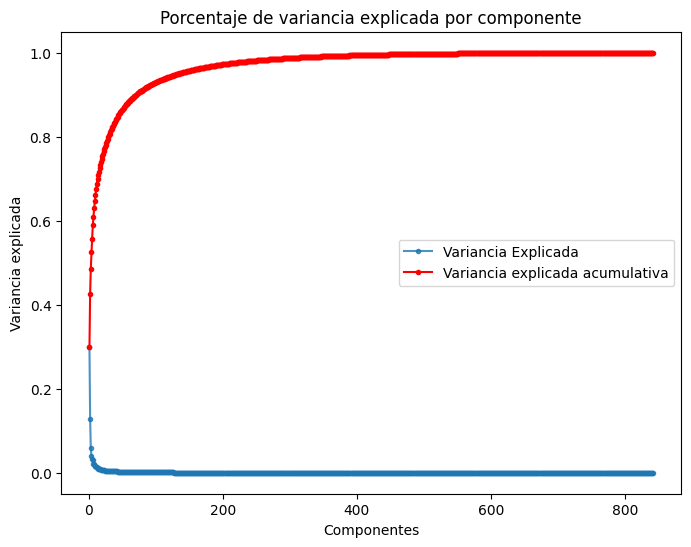

In [7]:
pca = PCA().fit(X_train)

fig = plt.figure(figsize=(8,6))
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada")
y_label = plt.ylabel('Variancia explicada')
x_label = plt.xlabel('Componentes')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa")
plt.legend()
plt.title('Porcentaje de variancia explicada por componente')

<Axes: >

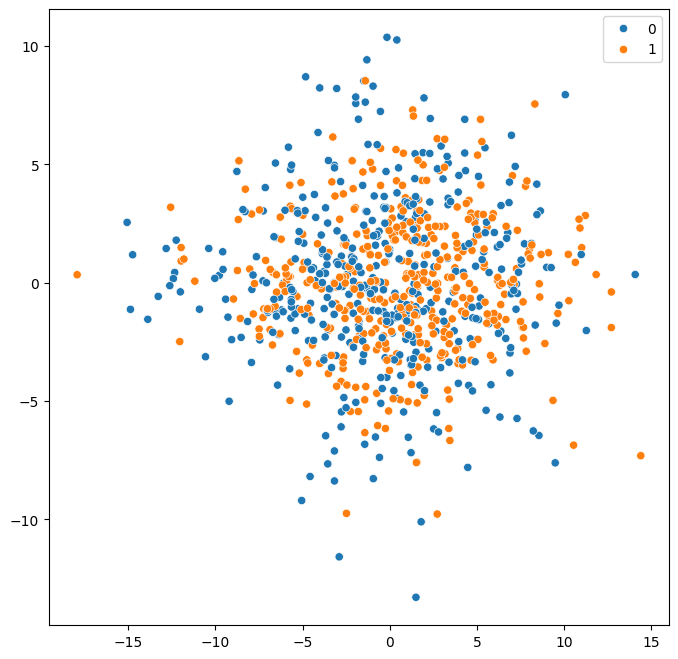

In [8]:
X_trans = pca.transform(X_train)
fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=X_trans[:,0],y=X_trans[:,1], hue=y_train)

Como se puede ver en el grafico, no hay una separabilidad clara entre las clases. Las diferentes clases de imagenes (sonriente y no sonriente) estan bastante mezcladas en el espacio 2D resultante de la reduccion de dimensionalidad con PCA. Esto sugiere que las caracteristicas extraidas de las imagenes no son lo suficientemente discriminativas para separar las dos clases de manera efectiva.

<Axes: >

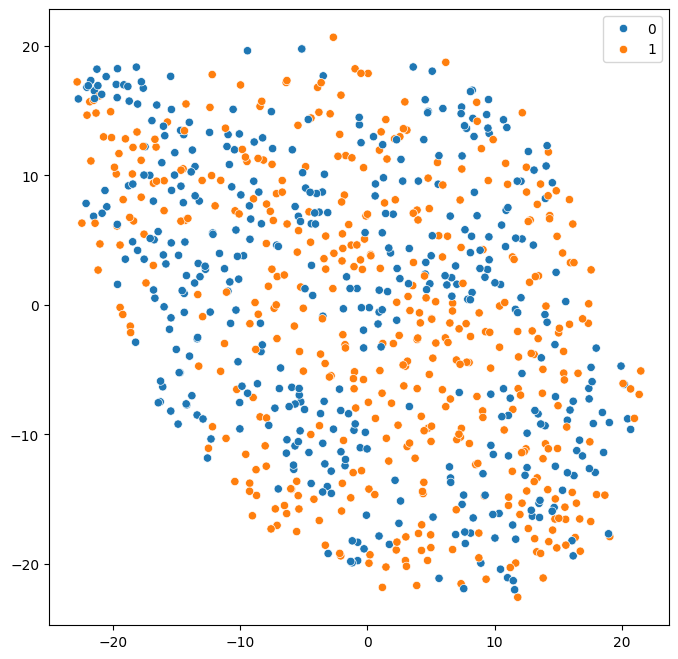

In [9]:
X_trans = TSNE(n_components=2, max_iter=2000, init='pca').fit_transform(X_train)
fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train)

Observando el grafico resultante del t-SNE, se puede ver que las clases tampoco estan claramente separadas. Aunque t-SNE tiende a formar grupos mas definidos que PCA, en este caso las imagenes de personas sonrientes y no sonrientes siguen estando bastante mezcladas.

---

b) Usaremos una red convolucional para entrenar el clasificador. En el código del notebook
 tienes una función que permite generar modelos de red convolucional variando diferentes
 parámetros. La red se define como una clase python donde en el método __init__ definimos los elementos de la red y en el forward como se hace la propagación hacia adelante
 en la red (la propagación hacia atrás se calcula automáticamente).  

 Para pasarle los datos a un modelo de torch hay que definir una clase del tipo Dataset,
 tienes una definida en el notebook a la que hay que pasarle la matriz de datos y el vector
 con las etiquetas. Esta clase se ha de pasar a un objeto Dataloader que se encarga de
 organizar el uso de los datos durante el entrenamiento, entre otras cosas de partir los datos en grupos (batch_size), podéis ver un ejemplo en el notebook.  
 
 Para entrenar los modelos usaremos la función train_loop que tenéis en el notebook. Esta función recibe el modelo, el optimizador a usar, los datos de entrenamiento y validación,
 la paciencia para la terminación temprana y el número de iteraciones que hará el entrenamiento. Para el optimizador usaremos adam, puedes ver en el notebook como generar el objeto del optimizador.  

 Empezaremos explorando el número y el tamaño de las capas y el tamaño del kernel de
 convolución. Entrena diferentes redes de 2 y 3 capas con tamaños para la primera capa 2, 4
 y 8. Para el resto ve doblando el tamaño de la primera capa para las capas sucesivas. Para
 los tamaños del kernel de convolución usa 3 y 5. Para crear la red solo tienes que crear
 un objeto de la clase convolutional pasándole los parámetros adecuados. Al generar el
 objeto tienes que subir el modelo a la GPU usando el método modelo.to(’cuda’) (si no
 torch se quejará dequelosdatosyelmodelonoestánenelmismodispositivo).Verásquela
 función de entrenamiento retorna la historia de la función de pérdida para el entrenamiento y validación. Usa esta información para comprobar el número de épocas que realmente se realizan antes de parar. La sobre especialización de la red la puedes comprobar con el conjunto de test. Puedes dejar la paciencia en su valor por defecto.

In [10]:
# Clase para definir la arquitectura de la red convolucional
class convolutional(nn.Module):
    def __init__(
        self,
        num_classes=2,
        input_size=32,
        input_channels=3,
        kernel_size=3,
        kernels=[16, 32],
        pooling=nn.MaxPool2d,
        batch_norm=False,
        dropout=0.0,
    ):
        super(convolutional, self).__init__()
        nkernels = [input_channels] + kernels
        padding = (kernel_size-1) // 2
        self.convo = []
        for k in range(1, len(nkernels)):
            self.convo.append(
                nn.Conv2d(
                    nkernels[k - 1],
                    nkernels[k],
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                )
            )
            self.convo.append(nn.ReLU())
            self.convo.append(pooling(kernel_size=2, stride=2))
            if batch_norm:
                self.convo.append(nn.BatchNorm2d(nkernels[k]))
            if dropout > 0:
                self.convo.append(nn.Dropout(dropout))
        self.convo = nn.Sequential(*self.convo)
        out_size = input_size // (2** len(kernels))
        self.fc = nn.Linear(out_size * out_size * nkernels[-1], num_classes)

    def forward(self, x):
        out = self.convo(x)
        return self.fc(out.view(out.size(0), -1))

In [11]:
# Primero necesitamos preparar los datos para la red convolucional
# Los datos deben tener forma (batch, channels, height, width)
X_train_conv = X_train.reshape(-1, 3, 32, 32)
X_val_conv = X_val.reshape(-1, 3, 32, 32)
X_test_conv = X_test.reshape(-1, 3, 32, 32)

smile_train = torch.utils.data.DataLoader(Smile(X_train_conv, y_train), batch_size=32)
smile_val = torch.utils.data.DataLoader(Smile(X_val_conv, y_val), batch_size=32)
smile_test = torch.utils.data.DataLoader(Smile(X_test_conv, y_test), batch_size=32)

In [ ]:

layers = [2, 3]
first_layer = [2,4,8]
kernel_size = [3, 5]
results = {}

for n_layers in layers:
    for first_size in first_layer:
        for k_size in kernel_size:
            # Generar la lista de kernels (doblando cada vez)
            kernels = [first_size * (2**i) for i in range(n_layers)]
            
            # Nombre descriptivo del modelo
            model_name = f"L{n_layers}_K{first_size}_KS{k_size}"
            print(f"\n{'='*60}")
            print(f"Entrenando: {model_name}")
            print(f"Capas: {n_layers}, Kernels: {kernels}, Kernel size: {k_size}")
            print(f"{'='*60}")
            
            # Crear el modelo
            model = convolutional(
                kernel_size=k_size,
                kernels=kernels
            ).to('cuda')
            
            # Crear el optimizador
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
            
            # Entrenar el modelo
            hist = train_loop(model, smile_train, smile_val, optimizer)
            
            # Evaluar en el conjunto de test
            model.eval()
            with torch.no_grad():
                y_pred, y_true = test_model(model, smile_test)
            
            # Calcular métricas
            test_acc = accuracy_score(y_true, y_pred)
            epochs_trained = len(hist['train'])
            
            # Guardar resultados
            results[model_name] = {
                'model': model,
                'history': hist,
                'test_accuracy': test_acc,
                'epochs': epochs_trained,
                'kernels': kernels,
                'kernel_size': k_size,
                'y_pred': y_pred,
                'y_true': y_true
            }
            
            print(f"\nÉpocas entrenadas: {epochs_trained}")
            print(f"Precisión en test: {test_acc:.4f}")
            print(f"Loss final train: {hist['train'][-1]:.4f}")
            print(f"Loss final val: {hist['val'][-1]:.4f}")


Entrenando: L2_K2_KS3
Capas: 2, Kernels: [2, 4], Kernel size: 3


  0%|          | 0/100 [00:00<?, ?it/s]


Épocas entrenadas: 100
Precisión en test: 0.8840
Loss final train: 0.3261
Loss final val: 0.3594

Entrenando: L2_K2_KS5
Capas: 2, Kernels: [2, 4], Kernel size: 5


  0%|          | 0/100 [00:00<?, ?it/s]


Épocas entrenadas: 100
Precisión en test: 0.8895
Loss final train: 0.2483
Loss final val: 0.2685

Entrenando: L2_K4_KS3
Capas: 2, Kernels: [4, 8], Kernel size: 3


  0%|          | 0/100 [00:00<?, ?it/s]


Épocas entrenadas: 100
Precisión en test: 0.8564
Loss final train: 0.2928
Loss final val: 0.3225

Entrenando: L2_K4_KS5
Capas: 2, Kernels: [4, 8], Kernel size: 5


  0%|          | 0/100 [00:00<?, ?it/s]


Épocas entrenadas: 100
Precisión en test: 0.9006
Loss final train: 0.2537
Loss final val: 0.3446

Entrenando: L2_K8_KS3
Capas: 2, Kernels: [8, 16], Kernel size: 3


  0%|          | 0/100 [00:00<?, ?it/s]


Épocas entrenadas: 100
Precisión en test: 0.8950
Loss final train: 0.2439
Loss final val: 0.2847

Entrenando: L2_K8_KS5
Capas: 2, Kernels: [8, 16], Kernel size: 5


  0%|          | 0/100 [00:00<?, ?it/s]


Épocas entrenadas: 89
Precisión en test: 0.9171
Loss final train: 0.1535
Loss final val: 0.2483

Entrenando: L3_K2_KS3
Capas: 3, Kernels: [2, 4, 8], Kernel size: 3


  0%|          | 0/100 [00:00<?, ?it/s]


Épocas entrenadas: 100
Precisión en test: 0.8066
Loss final train: 0.4132
Loss final val: 0.4663

Entrenando: L3_K2_KS5
Capas: 3, Kernels: [2, 4, 8], Kernel size: 5


  0%|          | 0/100 [00:00<?, ?it/s]


Épocas entrenadas: 100
Precisión en test: 0.8895
Loss final train: 0.2256
Loss final val: 0.3004

Entrenando: L3_K4_KS3
Capas: 3, Kernels: [4, 8, 16], Kernel size: 3


  0%|          | 0/100 [00:00<?, ?it/s]


Épocas entrenadas: 100
Precisión en test: 0.8453
Loss final train: 0.2780
Loss final val: 0.3395

Entrenando: L3_K4_KS5
Capas: 3, Kernels: [4, 8, 16], Kernel size: 5


  0%|          | 0/100 [00:00<?, ?it/s]


Épocas entrenadas: 100
Precisión en test: 0.9061
Loss final train: 0.1822
Loss final val: 0.2839

Entrenando: L3_K8_KS3
Capas: 3, Kernels: [8, 16, 32], Kernel size: 3


  0%|          | 0/100 [00:00<?, ?it/s]


Épocas entrenadas: 84
Precisión en test: 0.9171
Loss final train: 0.1548
Loss final val: 0.2451

Entrenando: L3_K8_KS5
Capas: 3, Kernels: [8, 16, 32], Kernel size: 5


  0%|          | 0/100 [00:00<?, ?it/s]


Épocas entrenadas: 73
Precisión en test: 0.9503
Loss final train: 0.1088
Loss final val: 0.2111


In [13]:
# Crear DataFrame con resultados
results_df = pd.DataFrame([
    {
        'Modelo': name,
        'Capas': len(res['kernels']),
        'Primera capa': res['kernels'][0],
        'Kernels': str(res['kernels']),
        'Kernel size': res['kernel_size'],
        'Épocas': res['epochs'],
        'Test Accuracy': res['test_accuracy'],
        'Train Loss': res['history']['train'][-1],
        'Val Loss': res['history']['val'][-1]
    }
    for name, res in results.items()
])

# Ordenar por precisión de test
results_df = results_df.sort_values('Test Accuracy', ascending=False)
print(results_df.to_string(index=False))

   Modelo  Capas  Primera capa     Kernels  Kernel size  Épocas  Test Accuracy  Train Loss  Val Loss
L3_K8_KS5      3             8 [8, 16, 32]            5      73       0.950276    0.108792  0.211098
L2_K8_KS5      2             8     [8, 16]            5      89       0.917127    0.153500  0.248290
L3_K8_KS3      3             8 [8, 16, 32]            3      84       0.917127    0.154763  0.245084
L3_K4_KS5      3             4  [4, 8, 16]            5     100       0.906077    0.182183  0.283901
L2_K4_KS5      2             4      [4, 8]            5     100       0.900552    0.253691  0.344640
L2_K8_KS3      2             8     [8, 16]            3     100       0.895028    0.243945  0.284728
L2_K2_KS5      2             2      [2, 4]            5     100       0.889503    0.248339  0.268518
L3_K2_KS5      3             2   [2, 4, 8]            5     100       0.889503    0.225575  0.300446
L2_K2_KS3      2             2      [2, 4]            3     100       0.883978    0.326092 

TODO: Comentar los resultados obtenidos en función de los parámetros usados.

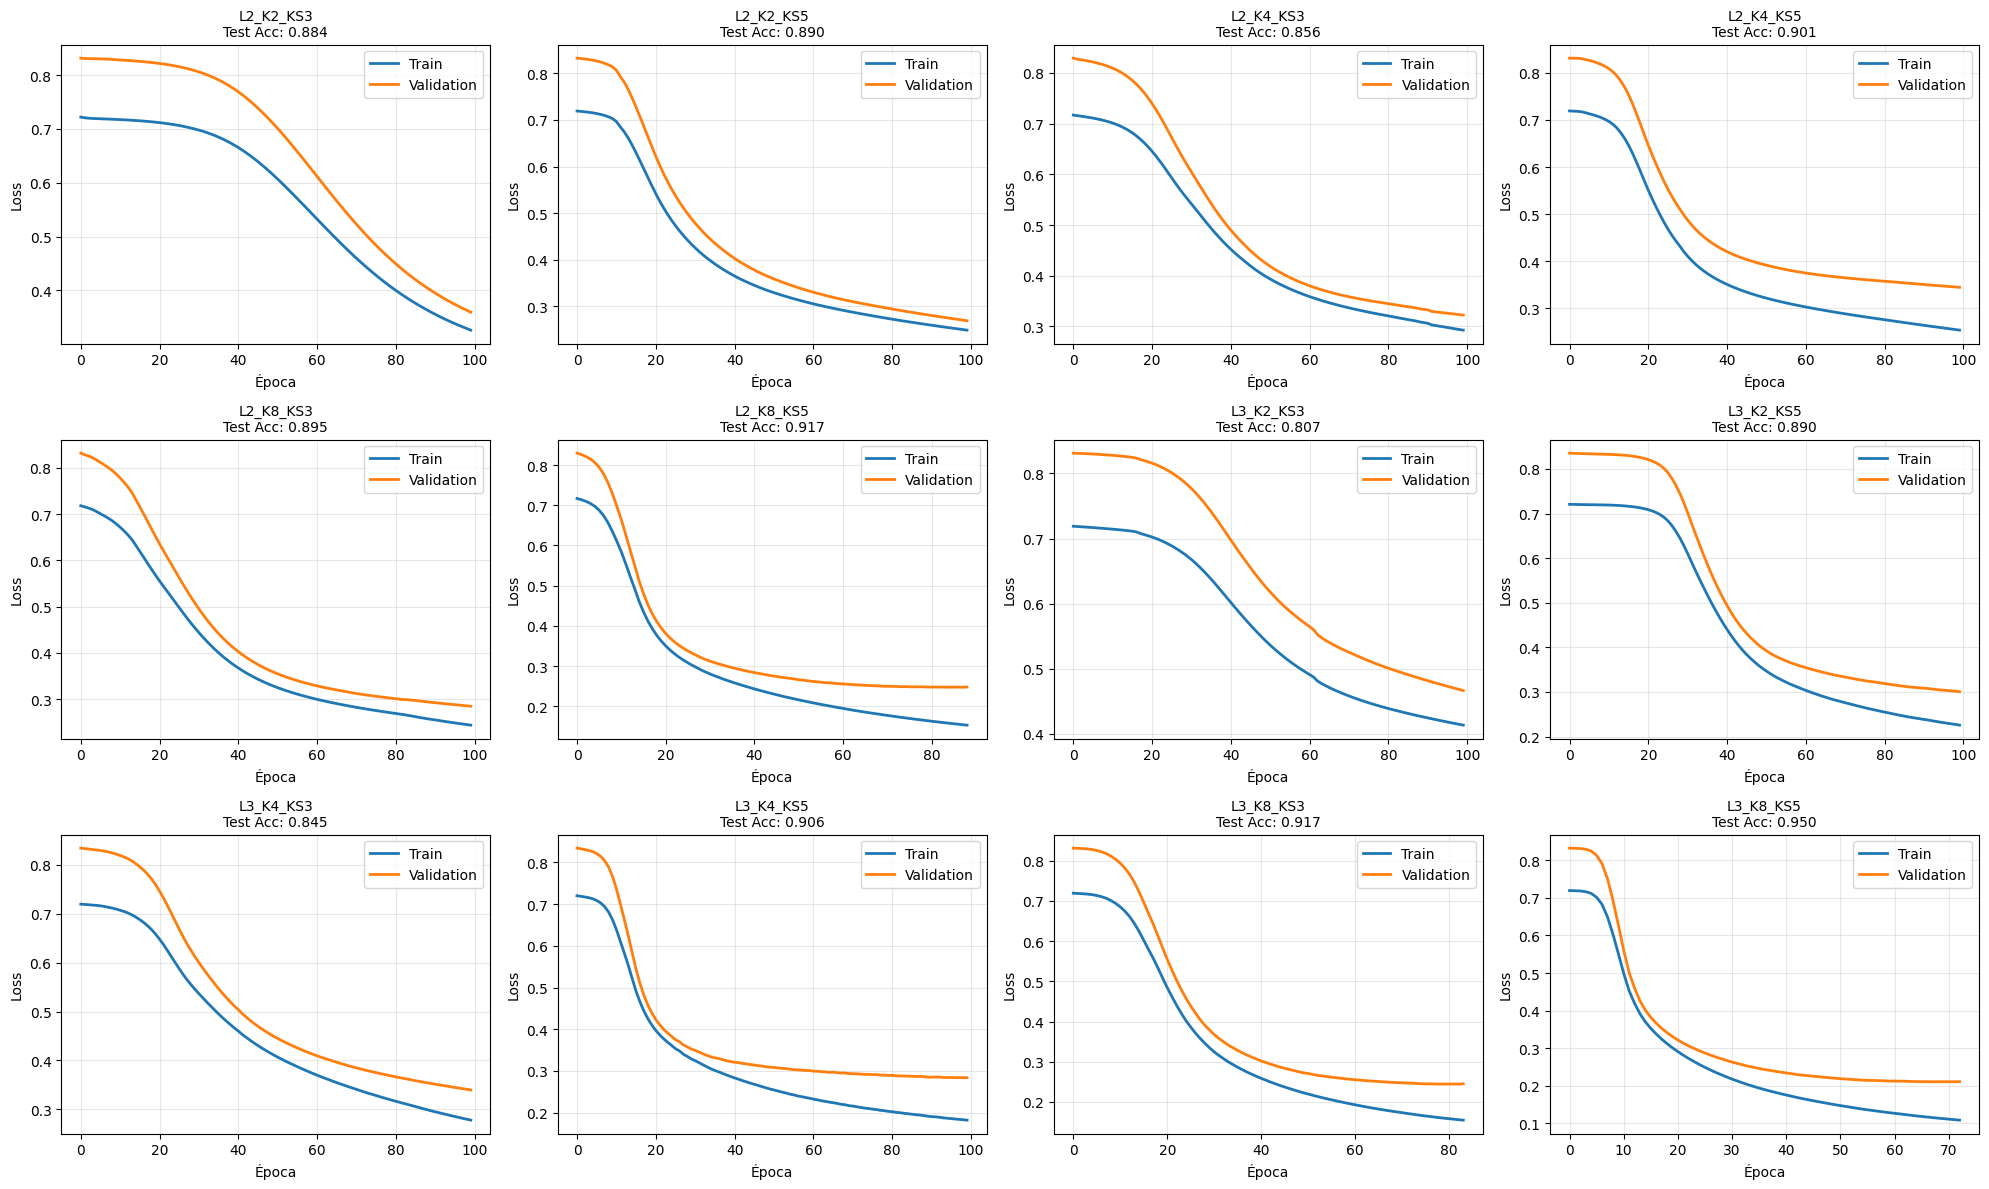

In [14]:
# Visualizar la evolución de la pérdida para cada modelo
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.flatten()

for idx, (name, res) in enumerate(results.items()):
    ax = axes[idx]
    ax.plot(res['history']['train'], label='Train', linewidth=2)
    ax.plot(res['history']['val'], label='Validation', linewidth=2)
    ax.set_title(f"{name}\nTest Acc: {res['test_accuracy']:.3f}", fontsize=10)
    ax.set_xlabel('Época')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Accuracy: 0.9503

Classification report:

              precision    recall  f1-score   support

    No-Smile       0.97      0.94      0.95       101
       Smile       0.93      0.96      0.94        80

    accuracy                           0.95       181
   macro avg       0.95      0.95      0.95       181
weighted avg       0.95      0.95      0.95       181



<Figure size 800x800 with 0 Axes>

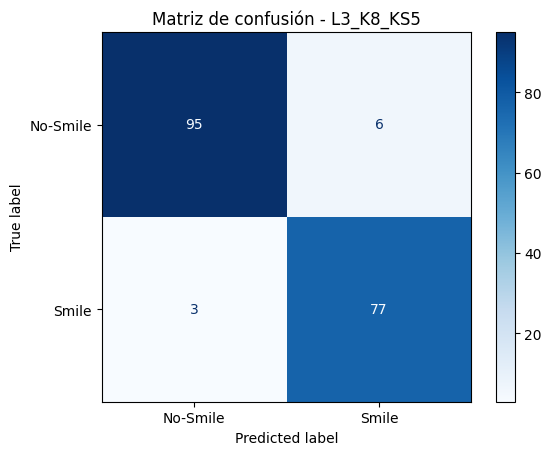

In [15]:
best_model = 'L3_K8_KS5'
y_true = results[best_model]["y_true"]
y_pred = results[best_model]["y_pred"]

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=['No-Smile', 'Smile']))

plt.figure(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=['No-Smile', 'Smile'],
    cmap='Blues'
)
plt.title(f"Matriz de confusión - {best_model}")
plt.show()

TODO: Comentar los resultados obtenidos en función de los parámetros usados.

---

 c) Verás en la implementación de la red que se usan una capa de pooling. Estas capas reducen el tamaño de la entrada haciendo una operación sobre grupos de valores vecinos.
 Por defecto usa MaxPool2d reduciendo el tamaño de la entrada a la cuarta parte (la mitad
 en dos dimensiones) usando el valor máximo de activación de cuatro valores contiguos.
 Otra posibilidad es usar la media de los valores con la capa AvgPool2D. Ajusta redes con
 el número de capas y el tamaño de kernel que te dio mejor resultado en el apartado anterior usando esta capa de pooling. Puedes evaluar la sobre especialización del modelo y
 evaluarlo de la misma manera que en el apartado anterior. Compara los resultados.

In [ ]:

# Configuraciones
pooling_types = [
    ('MaxPool', nn.MaxPool2d),
    ('AvgPool', nn.AvgPool2d)
]
best_kernel_size = 5
best_kernels = [8 * (2**i) for i in range(3)]


results_pooling = {}

for pool_name, pool_func in pooling_types:
        model_name = f"{pool_name}_K{best_kernels[0]}_KS{best_kernel_size}"
        print(f"\n{'='*60}")
        print(f"Entrenando: {model_name}")
        print(f"{'='*60}")
        
        # Crear el modelo con el tipo de pooling específico
        model = convolutional(
            kernel_size=best_kernel_size,
            kernels=best_kernels,
            pooling=pool_func  # ← Aquí se especifica el tipo de pooling
        ).to('cuda')
        
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        hist = train_loop(model, smile_train, smile_val, optimizer)
        
        # Evaluar
        model.eval()
        with torch.no_grad():
            y_pred, y_true = test_model(model, smile_test)
        
        test_acc = accuracy_score(y_true, y_pred)
        
        results_pooling[model_name] = {
            'model': model,
            'history': hist,
            'test_accuracy': test_acc,
            'epochs': len(hist['train']),
            'pooling': pool_name,
            'y_pred': y_pred,
            'y_true': y_true
        }
        
        print(f"\nÉpocas: {len(hist['train'])}")
        print(f"Test Accuracy: {test_acc:.4f}")


Entrenando: MaxPool_K8_KS5


  0%|          | 0/100 [00:00<?, ?it/s]


Épocas: 51
Test Accuracy: 0.9171

Entrenando: AvgPool_K8_KS5


  0%|          | 0/100 [00:00<?, ?it/s]


Épocas: 46
Test Accuracy: 0.8729


        Modelo Pooling  Épocas  Test Accuracy  Train Loss  Val Loss
MaxPool_K8_KS5 MaxPool      51       0.917127    0.142031  0.239885
AvgPool_K8_KS5 AvgPool      46       0.872928    0.276883  0.347223


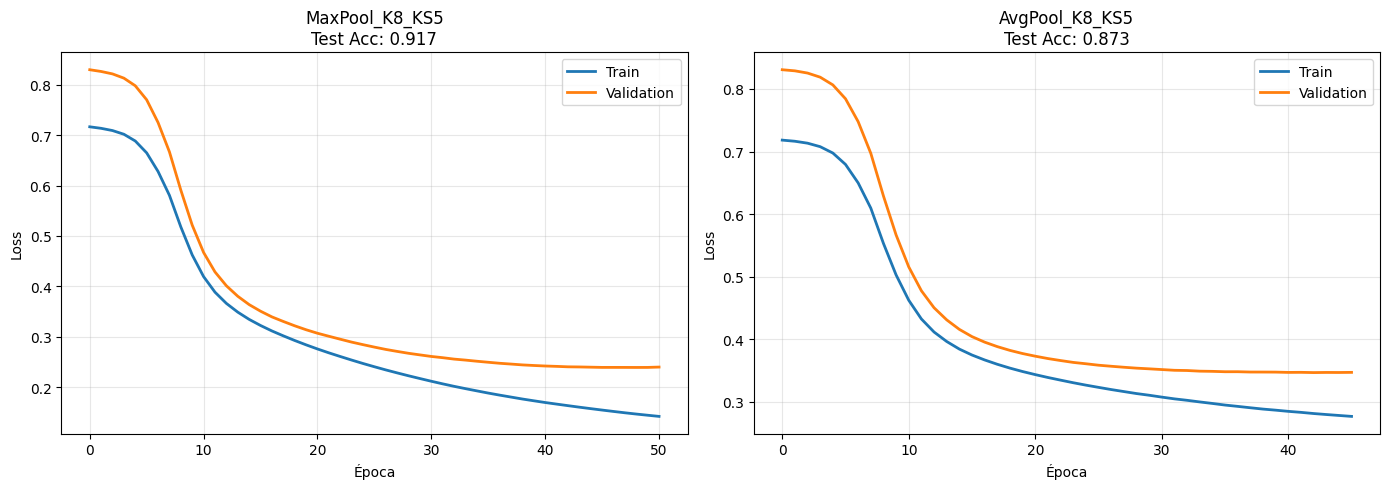

In [17]:
# Tabla comparativa
pooling_df = pd.DataFrame([
    {
        'Modelo': name,
        'Pooling': res['pooling'],
        'Épocas': res['epochs'],
        'Test Accuracy': res['test_accuracy'],
        'Train Loss': res['history']['train'][-1],
        'Val Loss': res['history']['val'][-1]
    }
    for name, res in results_pooling.items()
])

print(pooling_df.to_string(index=False))

# Visualizar comparación
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (name, res) in enumerate(results_pooling.items()):
    axes[idx].plot(res['history']['train'], label='Train', linewidth=2)
    axes[idx].plot(res['history']['val'], label='Validation', linewidth=2)
    axes[idx].set_title(f"{name}\nTest Acc: {res['test_accuracy']:.3f}")
    axes[idx].set_xlabel('Época')
    axes[idx].set_ylabel('Loss')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

TODO: Comenta los resultados obtenidos en función de los parámetros usados.

---
 d) Habrás visto que las implementaciones de las redes tienen dos capas opcionales BatchNorm2D y Dropout. La primera utiliza estadísticas de las activaciones calculadas a partir de los datos para normalizarlas durante el entrenamiento, esto estabiliza el entrenamiento y actúa
 como una regularización. La segunda hace cero de manera aleatoria las activaciones que le llegan. Esto evita que la red dependa específicamente de alguna de las entradas que le llegan a las capas y actúa también como una regularización.  

 Repite el entrenamiento del apartado anterior escogiendo la capa de pooling que funcionó
 mejor activando BatchNorm2D. Haz lo mismo usando la capa de dropout usando como
 valores 0.05 y 0.01. Tendrás que aumentar la paciencia en el entrenamiento un poco para estos experimentos para que no acaben enseguida. Ahora podemos ver el efecto de combinar las dos capas, ajusta las redes usando BatchNorm2D y el mejor valor de dropout.
 Compara los resultados y comenta las diferencias que hayas visto en como evoluciona la
 función de pérdida usando estas regularizaciones y el efecto en el número de épocas que
 hace la red



In [23]:
dropout = [0.05, 0.01]
batch_norm = [True, False]

results_do = {}

for drop in dropout:
    for batch in batch_norm:
        model_name = f"D{drop}_BN{batch}_K{best_kernels[0]}_KS{best_kernel_size}"
        
        print(f"\n{'='*60}")
        print(f"Entrenando: {model_name}")
        print(f"Dropout: {drop}, BatchNorm: {batch}")
        print(f"{'='*60}")
        model = convolutional(
            kernel_size = best_kernel_size,
            kernels = best_kernels,
            batch_norm=batch,
            dropout=drop
        ).to('cuda')
        
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        hist = train_loop(model, smile_train, smile_val, optimizer, patience=50, epochs=100)
        
        # Evaluar
        model.eval()
        with torch.no_grad():
            y_pred, y_true = test_model(model, smile_test)
        
        test_acc = accuracy_score(y_true, y_pred)
        
        results_do[model_name] = {
            'model': model,
            'history': hist,
            'test_accuracy': test_acc,
            'epochs': len(hist['train']),
            'dropout': drop,
            'batch_norm': batch,
            'y_pred': y_pred,
            'y_true': y_true
        }
        
        print(f"\nÉpocas: {len(hist['train'])}")
        print(f"Test Accuracy: {test_acc:.4f}")


Entrenando: D0.05_BNTrue_K8_KS5
Dropout: 0.05, BatchNorm: True


  0%|          | 0/100 [00:00<?, ?it/s]


Épocas: 75
Test Accuracy: 0.9724

Entrenando: D0.05_BNFalse_K8_KS5
Dropout: 0.05, BatchNorm: False


  0%|          | 0/100 [00:00<?, ?it/s]


Épocas: 100
Test Accuracy: 0.9448

Entrenando: D0.01_BNTrue_K8_KS5
Dropout: 0.01, BatchNorm: True


  0%|          | 0/100 [00:00<?, ?it/s]


Épocas: 79
Test Accuracy: 0.9779

Entrenando: D0.01_BNFalse_K8_KS5
Dropout: 0.01, BatchNorm: False


  0%|          | 0/100 [00:00<?, ?it/s]


Épocas: 85
Test Accuracy: 0.9337


In [24]:
# Tabla comparativa
dropout_df = pd.DataFrame([
    {
        'Modelo': name,
        'Dropout': res['dropout'],
        'BatchNorm': res['batch_norm'],
        'Épocas': res['epochs'],
        'Test Accuracy': res['test_accuracy'],
        'Train Loss': res['history']['train'][-1],
        'Val Loss': res['history']['val'][-1]
    }
    for name, res in results_do.items()
])

# Ordenar por test accuracy
dropout_df = dropout_df.sort_values('Test Accuracy', ascending=False)
print(dropout_df.to_string(index=False))

              Modelo  Dropout  BatchNorm  Épocas  Test Accuracy  Train Loss  Val Loss
 D0.01_BNTrue_K8_KS5     0.01       True      79       0.977901    0.002061  0.115910
 D0.05_BNTrue_K8_KS5     0.05       True      75       0.972376    0.005038  0.148475
D0.05_BNFalse_K8_KS5     0.05      False     100       0.944751    0.130103  0.235212
D0.01_BNFalse_K8_KS5     0.01      False      85       0.933702    0.133854  0.294346


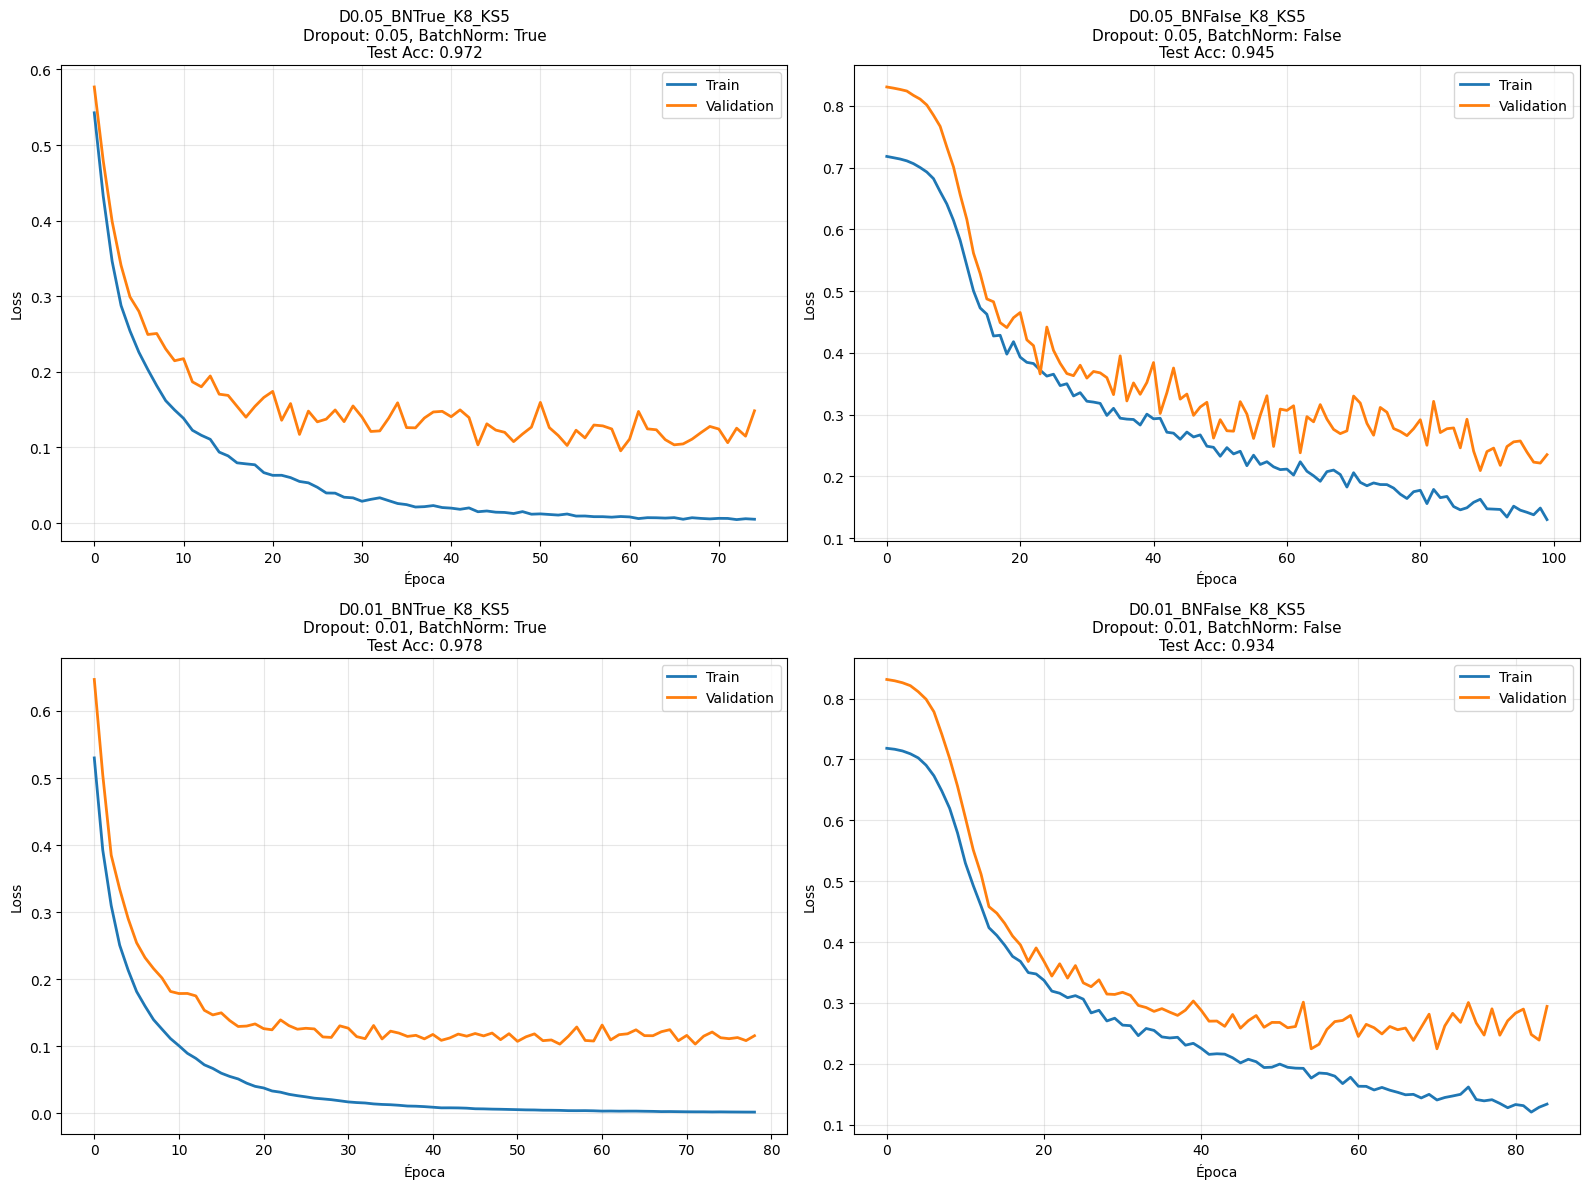

In [25]:
# Visualizar comparación de los 4 modelos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (name, res) in enumerate(results_do.items()):
    axes[idx].plot(res['history']['train'], label='Train', linewidth=2)
    axes[idx].plot(res['history']['val'], label='Validation', linewidth=2)
    axes[idx].set_title(
        f"{name}\nDropout: {res['dropout']}, BatchNorm: {res['batch_norm']}\nTest Acc: {res['test_accuracy']:.3f}",
        fontsize=11
    )
    axes[idx].set_xlabel('Época')
    axes[idx].set_ylabel('Loss')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hay que tener en cuenta que hemos aumentado la paciencia para permitir un entrenamiento mas largo (50 en lugar de 5), puede que por eso exista este ruido en los resultados.

MEJOR MODELO: D0.01_BNTrue_K8_KS5

Accuracy: 0.9779
Dropout: 0.01
BatchNorm: True
Épocas: 79

Classification report:

              precision    recall  f1-score   support

    No-Smile       0.97      0.99      0.98       101
       Smile       0.99      0.96      0.97        80

    accuracy                           0.98       181
   macro avg       0.98      0.98      0.98       181
weighted avg       0.98      0.98      0.98       181



<Figure size 800x800 with 0 Axes>

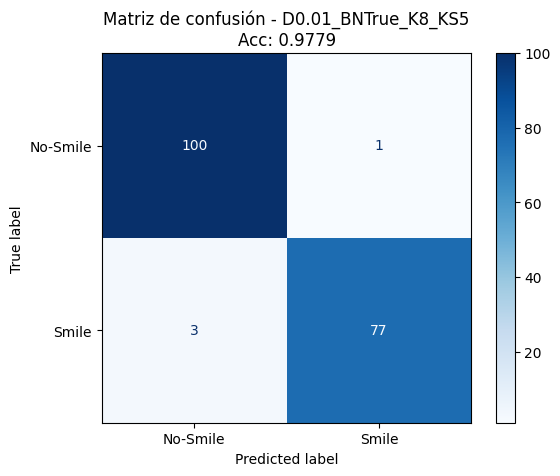

In [27]:
# Encontrar el mejor modelo
best_do_model = dropout_df.iloc[0]['Modelo']
y_true_best = results_do[best_do_model]["y_true"]
y_pred_best = results_do[best_do_model]["y_pred"]

print(f"MEJOR MODELO: {best_do_model}\n")
print(f"Accuracy: {accuracy_score(y_true_best, y_pred_best):.4f}")
print(f"Dropout: {results_do[best_do_model]['dropout']}")
print(f"BatchNorm: {results_do[best_do_model]['batch_norm']}")
print(f"Épocas: {results_do[best_do_model]['epochs']}")

print("\nClassification report:\n")
print(classification_report(y_true_best, y_pred_best, target_names=['No-Smile', 'Smile']))

plt.figure(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(
    y_true_best,
    y_pred_best,
    display_labels=['No-Smile', 'Smile'],
    cmap='Blues'
)
plt.title(f"Matriz de confusión - {best_do_model}\nAcc: {accuracy_score(y_true_best, y_pred_best):.4f}")
plt.show()